# Simulation d'un modèle SEIR

In [1]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt

In [36]:
# Définition du modèle

def simulate_SEIR_model(y, t, beta, gamma, sigma):
    S, E, I, R = y
    N = S + E + I + R 
    
    # Equations
    dS_dt = - beta * S * I / N
    dE_dt = - beta * S * I / N - sigma * E
    dI_dt = sigma * E - gamma * I
    dR_dt = gamma * I
    
    
    return([dS_dt, dE_dt, dI_dt, dR_dt])

In [37]:
# Conditions initiales
S0 = 0.5 # Susceptibles
E0 = 0.4 # Exposé
I0 = 0.1 # Infecté 
R0 = 0.0 # Recovered
beta = .8 # taux d'infection
sigma = .1 # taux d'incubation
gamma = 0.8 # taux taux de recovery

# Time vector
t = np.linspace(0, 100, 10000)

#Résultat
solution = scipy.integrate.odeint(simulate_SEIR_model, [S0, I0, E0, R0], t, args = (beta, gamma, sigma))
solution = np.array(solution)

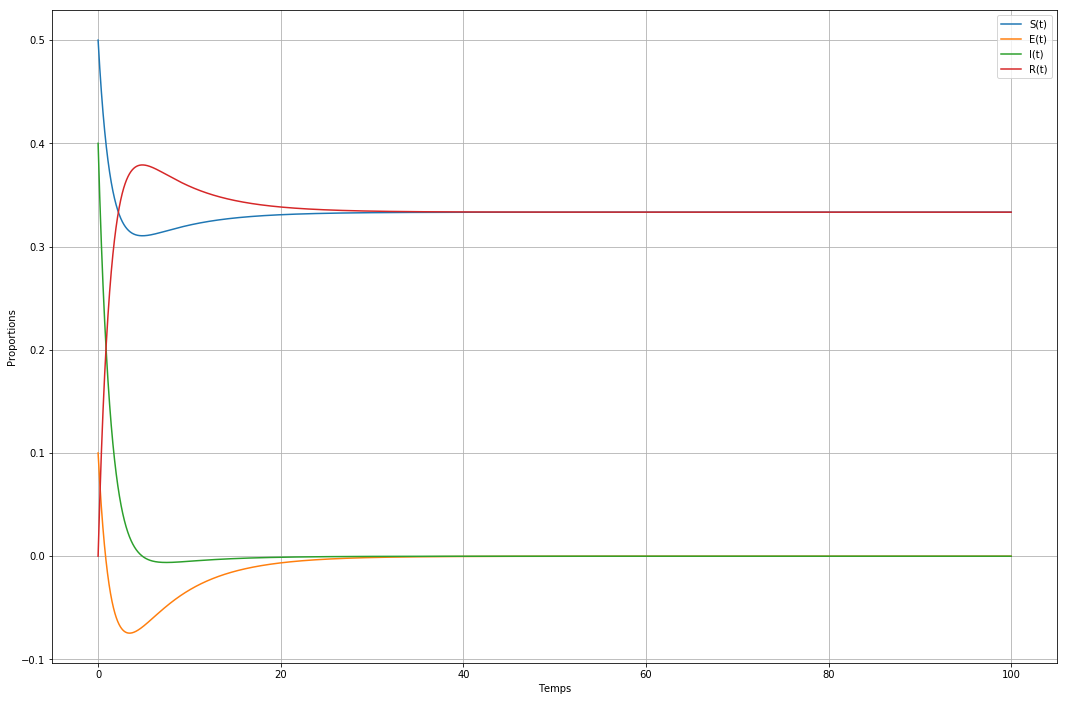

In [38]:
# Affichage des résultats

plt.figure(figsize = [18, 12])

plt.plot(t, solution[:,0], label = "S(t)")
plt.plot(t, solution[:,1], label = "E(t)")
plt.plot(t, solution[:,2], label = "I(t)")
plt.plot(t, solution[:,3], label = "R(t)")
plt.grid()
plt.legend()
plt.xlabel("Temps")
plt.ylabel("Proportions")

plt.show()